# Setup

In [1]:
# installations
# !pip install tensorflow
# !pip install keras

In [443]:
# imports
import numpy as np
import pandas

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 

import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, Input, activations, optimizers, losses, callbacks

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import json
import re
import pickle
import io
from collections import Counter, defaultdict
from tabulate import tabulate
import random

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
# nltk downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\philt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\philt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\philt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\philt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Load Dataset

In [445]:
df = pandas.read_csv('unbalanced_all_genres_top_10.csv')
df = df.drop(['ALink', 'SLink', 'Songs', 'language'], axis=1)
print(df.shape)

(110691, 5)


In [536]:
# map genres to their number encoding, and vice versa

# encoding_to_genre = {  # old version
#     0: 'Country',
#     1: 'Heavy Metal',
#     2: 'Hip Hop',
#     3: 'Indie',
#     4: 'Pop',
#     5: 'Pop/Rock',
#     6: 'R&B',
#     7: 'Rap',
#     8: 'Rock',
#     9: 'Rock Alternativo'
# }

encoding_to_genre = {
    0: 'Country',
    1: 'Heavy Metal',
    2: 'Hip Hop',
    3: 'Indie',
    4: 'Pop',
    5: 'Rock',
}

genre_to_encoding = {g: e for e, g in encoding_to_genre.items()}
possible_genres = set(genre_to_encoding.keys())

In [537]:
RANDOM_SAMPLE = False
SAMPLES = 5000
df_sample = None

if RANDOM_SAMPLE:
    df_sample = df.sample(n=SAMPLES)
else:
    df_sample = df
    SAMPLES = 'ALL'


# get the first genre out of the genres column
one_genre_col = []
to_drop = []
# rock_count = 0
for index, genres in enumerate(df_sample['Genres']):
    valid = False
    for g in genres.split('; '):
        if g == 'Rap':
            one_genre_col.append(genre_to_encoding['Hip Hop'])
            valid = True
            break
#         elif g == 'Rock':
#             rock_count += 1
#             if rock_count % 2 == 0:
#                 one_genre_col.append(genre_to_encoding[g])
#                 valid = True
#                 break
        elif g in possible_genres:
            one_genre_col.append(genre_to_encoding[g])
            valid = True
            break
    if not valid:
        to_drop.append(df_sample.index[index])

# create new column with the top genre of each song
df_sample = df_sample.drop(to_drop, axis=0)
df_sample['Top Genre'] = one_genre_col
    
top_genre_col = df_sample['Top Genre']

# use these documents in model
lyrics_col = df_sample['Lyric']

Counter({5: 30838, 2: 20277, 4: 17863, 3: 14778, 1: 13591, 0: 7377})


<BarContainer object of 6 artists>

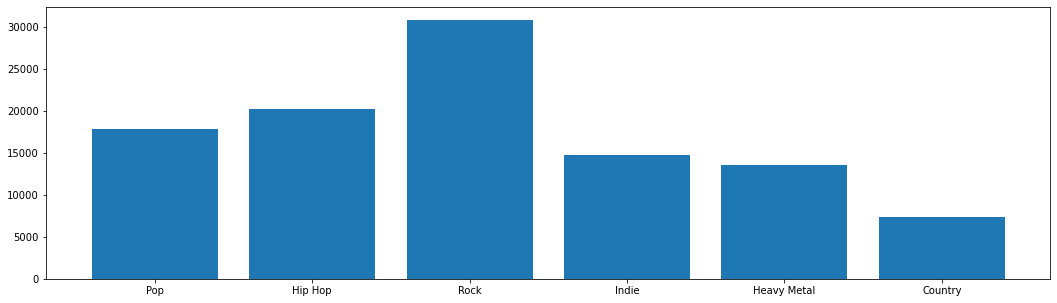

In [538]:
# display genre distributions
print(Counter(top_genre_col))
freq = Counter([encoding_to_genre[e] for e in top_genre_col])
f, ax = plt.subplots(figsize=(18,5))
ax.bar(list(freq.keys()), list(freq.values()))

# Preprocessing

* Stemming (Porter): removes prefixes/suffixes from word
* Lemmatization: extracts base form of word using word context
* Stopword Removal: removing common English words



In [539]:
INCLUDE_PUNCTUATION = False

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
extra_stop_words = {'chorus', 'lyric', 'lyrics', 'verse', 'intro', 'outro', 'bridge'}
alpha = re.compile(r'^[a-zA-Z]+$')    
all_tokens = []
to_drop = [] 
song_lengths = []
    
with open('processed_tokens_' + str(SAMPLES) + '.txt', 'w', encoding='utf-8') as outfile:
      for index, lyric in enumerate(lyrics_col): 

        df_index = lyrics_col.index[index]      # dataframe index may differ from enumerated index
        target_genre = genre_encoding_col[df_index]

        # extracting two genres at a time
        #     if target_genre not in {genre_to_encoding['Hip Hop'], genre_to_encoding['Rock']}:
        #         df = df.drop([index], axis=0)
        #         continue

        # tokenize
        raw_tokens = word_tokenize(lyric)

        # filter out lyrics that are too short or too long
        if len(raw_tokens) < 100 or len(raw_tokens) > 1000:
            # removing < 100 filter decreases accuracy, maybe too much zero-padding in vectors
            to_drop.append(df_index)
            song_lengths.append(len(doc_str.split(' ')))
            continue

    #     artist_name = set(artist_col[df_index].lower().split(' '))

        doc_str = ''
        for word in raw_tokens:
            word = word.lower()
            # remove stopwords
            if word not in stop_words and word not in extra_stop_words:
                # remove punctuation depending on setting
                if INCLUDE_PUNCTUATION or re.match(alpha, word):
                    # stem and lemmatize
                    processed_word = lemmatizer.lemmatize(stemmer.stem(word))
                    # write to file
                    doc_str += processed_word + ' '
                    outfile.write(processed_word + ' ')
        outfile.write('\n')
        
        song_lengths.append(len(doc_str.split(' ')))

        all_tokens.append(doc_str.rstrip())



Average number of tokens: 126.63


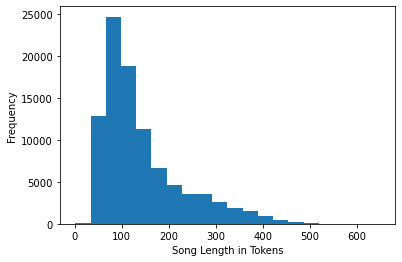

In [540]:
print('Average number of tokens: %.2f' %(sum(song_lengths) / (len(all_tokens) + len(to_drop))))
plt.xlabel("Song Length in Tokens")
plt.ylabel("Frequency")
plt.hist(song_lengths, bins=20)
plt.show() 

In [541]:
# drop rows with too few or too many tokens
df_sample = df_sample.drop(to_drop, axis=0)

# columns after unwanted rows are removed
lyrics_col = df_sample['Lyric']
all_genres_col = df_sample['Genres']
artist_col = df_sample['Artist']
song_name_col = df_sample['SName']
top_genre_col = df_sample['Top Genre']

labels = top_genre_col

In [542]:
len(all_tokens)

86893

In [441]:
# save sample of dataset to file for demo notebook
if RANDOM_SAMPLE:
    df_sample.to_csv('dataset_sample_' + str(SAMPLES) + '.csv')

# Generating Features

### Basic Bag of Words model

In [255]:
vectorizer = CountVectorizer()   # generates bag of words

docs = all_tokens
bag = vectorizer.fit_transform(docs)

print(vectorizer.get_feature_names()) # Get unique words / tokens found in all the documents. The unique words / tokens represents the features
print(vectorizer.vocabulary_) # Associate the indices with each unique word
print(bag.toarray()) # Print the numerical feature vector

X = bag.toarray()
y = labels

['aa', 'aaa', 'aaaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaaaaaah', 'aaaaaaaaaaaaaaaahhh', 'aaaaaaaaaaaaaaahhhh', 'aaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaah', 'aaaaaaaaaaaaauuuuuu', 'aaaaaaaaaaaah', 'aaaaaaaaaaaahhhhhhhhhhhhh', 'aaaaaaaaaaaal', 'aaaaaaaaaaaggghhhhhhhhhhhhhh', 'aaaaaaaaaaah', 'aaaaaaaaaaahhhhhhhhh', 'aaaaaaaaaah', 'aaaaaaaaaahhh', 'aaaaaaaaaahhhhhhh', 'aaaaaaaaaahhhhhhhh', 'aaaaaaaaaaoooow', 'aaaaaaaaah', 'aaaaaaaah', 'aaaaaaaahhhhhhhhhhhh', 'aaaaaaaahhhhhhhhhhhhh', 'aaaaaaaawwwooooooowwwaaaaaaaooo', 'aaaaaaah', 'aaaaaaahh', 'aaaaaaahhhhhhhh', 'aaaaaaahhhhhhhhhhhhh', 'aaaaaaahhhhhhhhhiiiiiii', 'aaaaaah', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhh', 'aaaaaahhhhhhh', 'aaaaaahhhhhhhhhhhhhhh', 'aaaaaam', 'aaaaaarggghhh', 'aaaaaarrghh', 'aaaaaawwwwwwwoooooooooo', 'aaaaaghhh'

C:\Users\philt\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


MemoryError: Unable to allocate 57.2 GiB for an array with shape (89072, 86128) and data type int64

### Logistic Regression using BAG OF WORDS

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/ 
#https://refactored.ai/microcourse/notebook?path=content%2F06-Classification_models_in_Machine_Learning%2F02-Multivariate_Logistic_Regression%2Fmulticlass_logistic-regression.ipynb
lr = LogisticRegression(C=10.0, random_state=1, solver='lbfgs', multi_class='multinomial') # ovr vs multinominal, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
lr.fit(X_train, y_train)

y_pred_bow = lr.predict(X_test)

print("LogisticRegression Accuracy %.3f" %metrics.accuracy_score(y_test, y_pred_bow))

C:\Users\philt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy 0.330


### GloVe embeddings using Stanford's model

https://datamahadev.com/stanfords-glove-implementation-using-python/


GloVe training is done in **glove.ipynb**. 
Use Colab instead to custom-train GloVe model, glove-python library can't be installed in jupyter for some reason

In [543]:
# APPROACH 1: use custom-trained GloVe embeddings

glove_vectors = []
with open('glove_vectors.txt', 'r', encoding='utf-8') as infile:
    for line in infile:
        vec = np.asarray(line.split(' ')[0:-1], dtype=float)
        glove_vectors.append(vec)
        
glove_dictionary = {}
with open('glove_dictionary.json', 'r') as jsonfile:
    glove_dictionary = json.load(jsonfile)
            

In [190]:
# APPROACH 2: use pre-trained GloVe embeddings
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

embeddings_dict = {}
with open("pretrained_glove.6B/glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float64")
        embeddings_dict[word] = vector

Lyric vectors have to be the same length. 
possible approaches
* using this: pad with 0 vector, and ignore songs with lyrics > max_words
* alternative: only use the first n words in the lyrics, and ignore songs with lyrics < min_words


In [544]:
# construct embedding vectors to be used as features 

EMBEDDING_LENGTH = 600
PRE_TRAINED = False

embeddings = []

for count, doc_tokens in enumerate(all_tokens):
    emb_avgs = []
    for token in doc_tokens.split(' '):
        # average glove embeddings vector for token
        # add this average to the document vector
        if PRE_TRAINED:
            emb_avgs.append(np.average(embeddings_dict[word]))
        else:
            if token in glove_dictionary:
                emb_avgs.append(np.average(glove_vectors[glove_dictionary[token]]))
            else:
                emb_avgs.append(0)
    emb_avgs = np.array(emb_avgs)
    
    # pad with zeroes if not enough words in song
    if len(emb_avgs) < EMBEDDING_LENGTH:
        emb_avgs = np.pad(emb_avgs, (0, EMBEDDING_LENGTH - len(emb_avgs)), 'constant')
    # cut off extra tokens if too many words in song
    else:
        emb_avgs = emb_avgs[:EMBEDDING_LENGTH]
        
    embeddings.append(emb_avgs)

embeddings = np.array(embeddings, dtype=float)

In [545]:
embeddings.shape  # (num songs, num words used for each song)

(86893, 600)


# Logistic Regression 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/ 
https://refactored.ai/microcourse/notebook?path=content%2F06-Classification_models_in_Machine_Learning%2F02-Multivariate_Logistic_Regression%2Fmulticlass_logistic-regression.ipynb

In [486]:
# counts prediction correct if predicted label is any one of the song's genres in the genre list
def lenient_accuracy(indices, predictions):
    correct = 0
    for test_index, df_index in enumerate(indices):
        for g in all_genres_col.tolist()[df_index].split('; '):
            if g == encoding_to_genre[predictions[test_index]]:
                correct += 1
                break
    return correct / len(predictions)

In [546]:
X = embeddings
y = labels
indices = np.arange(len(X))

X_train_lr, X_test_lr, y_train_lr, y_test_lr, indices_train_lr, indices_test_lr = train_test_split(X, y, indices)

lr = LogisticRegression(C=10.0, random_state=1, solver='newton-cg', multi_class='multinomial') # ovr vs multinominal, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
# tried class_weight='balanced'
lr.fit(X_train_lr, y_train_lr)

y_pred_lr = lr.predict(X_test_lr)

print('considering prediction correct if the song\'s top genre matches:')
print("Logistic Regression Validation Accuracy %.3f" %metrics.accuracy_score(y_test_lr, y_pred_lr))

y_pred_train = lr.predict(X_train_lr)
print("Logistic Regression Training Accuracy %.3f" %metrics.accuracy_score(y_train_lr, y_pred_train))

print('--------------------')
print('considering prediction correct if any of the song\'s genres match:')
print("%.3f" %lenient_accuracy(indices_test_lr, y_pred_lr))

considering prediction correct if the song's top genre matches:
Logistic Regression Validation Accuracy 0.421
Logistic Regression Training Accuracy 0.428
--------------------
considering prediction correct if any of the song's genres match:
0.503


In [503]:
# export model to pickle file
with open('lr_model.pkl','wb') as outfile:
    pickle.dump(lr, outfile)

# Multi-Layer Perceptron Neural Network

In [547]:
# simple NN

nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=800)

X_train_nn, X_test_nn, y_train_nn, y_test_nn, indices_train_nn, indices_test_nn = train_test_split(X, y, indices)

nn.fit(X_train_nn, y_train_nn)
y_pred_nn = nn.predict(X_test_nn)

print('considering prediction correct if the song\'s top genre matches:')
print("MLP Neural Network Validation Accuracy %.3f" %metrics.accuracy_score(y_test_nn, y_pred_nn))

y_pred_train = lr.predict(X_train_nn)
print("MLP Neural Network Training Accuracy %.3f" %metrics.accuracy_score(y_train_nn, y_pred_train))

print('--------------------')
print('considering prediction correct if any of the song\'s genres match:')
print("%.3f" %lenient_accuracy(indices_test_nn, y_pred_nn))

C:\Users\philt\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


considering prediction correct if the song's top genre matches:
MLP Neural Network Validation Accuracy 0.424
MLP Neural Network Training Accuracy 0.427
--------------------
considering prediction correct if any of the song's genres match:
0.510


# LSTM RNN

Resources: 

https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d

https://github.com/MohammadFneish7/Keras_LSTM_Diagram


In [81]:
# from sklearn.utils import compute_class_weight
# class_weight = compute_class_weight('balanced', classes=np.unique(labels), y=labels) 
# class_weight = dict(enumerate(class_weight))

In [402]:
X = np.array(embeddings)
y = np.array(labels) 
indices = np.arange(len(X))

# LSTM takes in a 3-dimensional vector (# samples, # timesteps (words in this case), # features per timestep)
X = X.reshape((len(embeddings), EMBEDDING_LENGTH, 1))
y = y.reshape((len(labels), 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

LSTM_UNITS = 64

rnn = Sequential([
#     layers.Embedding(input_dim=len(X_train[0]), output_dim=32, mask_zero=True),
#     layers.Bidirectional(layers.LSTM(32, input_shape=(600, 1))), # making LSTM bidirectional
    
    # two LSTM layers, with dropout in between for regularization
    layers.LSTM(LSTM_UNITS, input_shape=(EMBEDDING_LENGTH, 1), return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(LSTM_UNITS, input_shape=(EMBEDDING_LENGTH, 1)),

    layers.Dense(64, activation=activations.relu),   
    # 6 possible classes, so 6 nodes for softmax
    layers.Dense(6, activation=activations.softmax)
])

rnn.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(1e-4), # tried 1e-3, 1e-5
    # optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
    metrics=['accuracy', keras.metrics.SparseCategoricalAccuracy()]
)

rnn.summary()

# train RNN
callback = callbacks.EarlyStopping(monitor='loss', patience=3)
history = rnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=120, epochs=100, callbacks=[callback])

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 200, 64)           16896     
                                                                 
 dropout_42 (Dropout)        (None, 200, 64)           0         
                                                                 
 lstm_94 (LSTM)              (None, 64)                33024     
                                                                 
 dense_102 (Dense)           (None, 64)                4160      
                                                                 
 dense_103 (Dense)           (None, 7)                 455       
                                                                 
Total params: 54,535
Trainable params: 54,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
580/580 [============================

Epoch 33/100
580/580 [==============================] - 596s 1s/step - loss: 1.4500 - accuracy: 0.4282 - sparse_categorical_accuracy: 0.4282 - val_loss: 1.4389 - val_accuracy: 0.4322 - val_sparse_categorical_accuracy: 0.4322
Epoch 34/100
580/580 [==============================] - 596s 1s/step - loss: 1.4497 - accuracy: 0.4287 - sparse_categorical_accuracy: 0.4287 - val_loss: 1.4404 - val_accuracy: 0.4315 - val_sparse_categorical_accuracy: 0.4315
Epoch 35/100
580/580 [==============================] - 596s 1s/step - loss: 1.4494 - accuracy: 0.4276 - sparse_categorical_accuracy: 0.4276 - val_loss: 1.4421 - val_accuracy: 0.4320 - val_sparse_categorical_accuracy: 0.4320
Epoch 36/100
580/580 [==============================] - 14116s 24s/step - loss: 1.4490 - accuracy: 0.4284 - sparse_categorical_accuracy: 0.4284 - val_loss: 1.4370 - val_accuracy: 0.4333 - val_sparse_categorical_accuracy: 0.4333
Epoch 37/100
580/580 [==============================] - 815s 1s/step - loss: 1.4484 - accuracy: 0

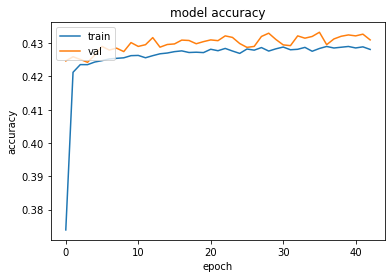

In [403]:
# plot accuracy during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [404]:
# evaluate LSTM
scores = rnn.evaluate(X,y,verbose=1,batch_size=100)
y_pred_lstm = rnn.predict(embeddings, batch_size=100)
y_pred_lstm = y_pred_lstm.argmax(axis=1)
print("when considering multiple genres: %.3f" % lenient_accuracy(indices, y_pred_lstm))

869/869 [==============================] - 381s 437ms/step
44571
86893
0.513


In [405]:
# export model 
rnn.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


# Accuracies

In [ ]:
# model comparisons
print("Logistic Regression Accuracy %.3f" %metrics.accuracy_score(y_test_lr, y_pred_lr))
print("MLP Neural Network Accuracy %.3f" %metrics.accuracy_score(y_test_nn, y_pred_nn))
print("LSTM RNN Accuracy %.3f" %metrics.accuracy_score(labels, y_pred_lstm))

print('\nwhen considering multiple genres: ')
print("Logistic Regression Accuracy %.3f" %lenient_accuracy(indices_test_lr, y_pred_lr))
print("MLP Neural Network Accuracy %.3f" %lenient_accuracy(indices_test_nn, y_pred_nn))
print("LSTM RNN Accuracy %.3f" %lenient_accuracy(indices, y_pred_lstm))

In [ ]:
def accuracies_by_genre(actual, pred):
    print('Accuracies by Genre')
    print('-------------------')
    for genre, encoding in genre_to_encoding.items():  
        total = 0
        numCorrect = 0
        for i in range(len(pred)):
            if encoding == actual[i]:
                total += 1
                if actual[i] == pred[i]:
                    numCorrect += 1
        if total > 0:
            print('{0: <20}: {1:.2f}%'.format(genre, numCorrect / total * 100))
            
            
def prediction_frequencies(pred):
    print("Frequencies of Predictions")
    guess_freq = defaultdict(int)
    for i in range(len(pred)):
        guess_freq[encoding_to_genre[pred[i]]] += 1
    for guess, freq in guess_freq.items():
        print('{: <20}: {} ({:.2f}%)'.format(guess, freq, freq/len(pred) * 100))
        

def example_predictions(indices, actual, pred, count=50, lenient=False):
    print('Predictions')
    print('-----------')
    headers = ['Song Name', 'Artist', 'Predicted', 'Actual', 'Correct?']
    print_data = []
    for i in random.sample(range(0, len(indices)), count): # get 50 random points from test data
        df_index = indices[i]
        correct = 'Yes' if pred[i] == actual[i] else 'No'
        if lenient:
            correct = 'No'
            for g in all_genres_col.tolist()[df_index].split('; '):
                if g == encoding_to_genre[pred[i]]:
                    correct = 'Yes'
                    break
        print_data.append([song_name_col.tolist()[df_index], artist_col.tolist()[df_index], 
                           encoding_to_genre[pred[i]], 
                            all_genres_col.tolist()[df_index],
                           correct, 
                          ])
    print(tabulate(print_data, headers=headers))

In [520]:
# get accuracy for each genre
accuracies_by_genre(y_test_lr.tolist(), y_pred_lr)
# accuracies_by_genre(labels.tolist(), y_pred_lstm)

Accuracies by Genre
-------------------
Country             : 0.08557213930348259
Heavy Metal         : 0.5787012987012987
Hip Hop             : 0.7388642600802195
Indie               : 0.2125114995400184
Pop                 : 0.5255851932498639


In [521]:
# how often each genre was guessed
prediction_frequencies(y_pred_lr)

Frequencies of Predictions
Heavy Metal         : 5660 (32.28%)
Pop                 : 4677 (26.68%)
Hip Hop             : 4631 (26.41%)
Indie               : 2205 (12.58%)
Country             : 359 (2.05%)


Observations on Genre Accuracies
* Heavy Metal is 0
    * most are classified as Rock
* Indie is also very low
* Rock has the highest accuracy
    * maybe model is overclassifying other genres as rock (maybe because rock has the most songs?)

In [388]:
# Example Predictions from Test Data
example_predictions(indices_test_lr, y_test_lr.tolist(), y_pred_lr, lenient=True)
# example_predictions(indices, labels.tolist(), y_pred_lstm, lenient=True)

Predictions
-----------
Song Name                                                    Artist                Predicted    Actual                            Correct?
-----------------------------------------------------------  --------------------  -----------  --------------------------------  ----------
How You Sell Soul To A Soulless People Who Sold Their Soul?  Public Enemy          Hip Hop      Rap                               No
Late Night Creepin'                                          Master P              Hip Hop      Rap; Hip Hop; Chillout            Yes
The Little Drummer Boy                                       Sufjan Stevens        Rock         Indie; Folk                       No
The Match                                                    Asking Alexandria     Rock         Rock; Hard Rock; Hardcore         Yes
24 Hrs                                                       Olly Murs             Rock         Pop                               No
Brown Eyed Handsome Man      

Other Tweaks to Try
* Pre-trained GloVe embeddings ✅
* Logistic model from scratch
* Changing static embedding length (currently 600) N=800 does a little bit better ✅
* remove words that don't count as lyrics e.g. chorus, intro, verse, bridge, lyric ✅
    * also artist names ✅ (accuracy is actually higher with artist names)
    * maybe don't include common words that are shared between genres e.g. love, like, know (this might affect glove embeddings)
* including punctuation vs not ✅
* higher dimensions of GloVe (increase no_components parameter), currently 5 components ✅
    * pre-trained has 100 components per word and uses learning rate = 0.05
    * change learning rate during glove training
* only use one of lemmatization or stemming, or switch the order ✅
* reduce the number of categories/genres (could be the reason why accuracy is low)  ✅
    * "Pop/Rock" genre is not good, "Rock Alternativo" might be too similar to "Rock"
* consider multiple genres for each lyric ✅
* balance dataset so that number of Rock songs is near the same as the other genres ✅
    * tried to make all the genres the same size, but then there wasn't enough data (0.271, all genres had 5300 songs)

# Data Visualizations


IndexError: index 2 is out of bounds for axis 0 with size 2

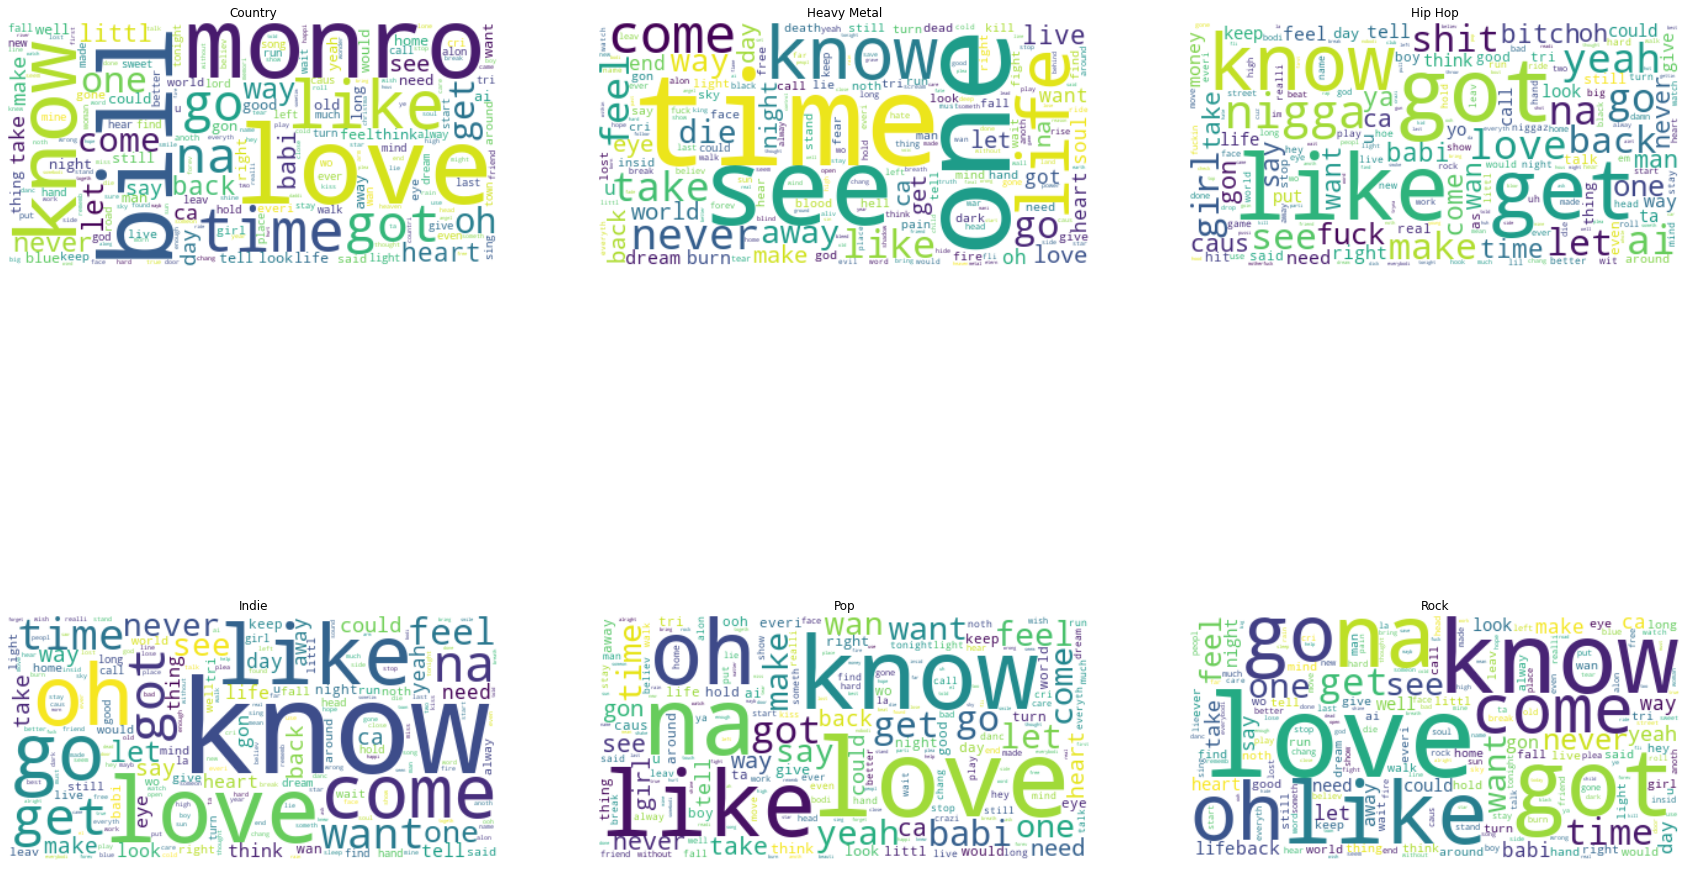

In [549]:
# word cloud of most common words from each genre

fig, ax = plt.subplots(2, 3, figsize=(30,20))
row = 0
col = 0
for genre, encoding in genre_to_encoding.items():  
    all_words = []
    for idx, doc in enumerate(all_tokens):
        if labels.tolist()[idx] == encoding:
            all_words.extend(doc.split(' '))

    freq = Counter(all_words)
    
    if len(freq) > 0:
        # use bag of words and predictions from glove
        word_cloud = WordCloud(collocations = False, background_color = 'white').generate_from_frequencies(freq)
    #     print(freq.most_common(100))

        ax[row, col].imshow(word_cloud, interpolation="bilinear")
        ax[row, col].axis("off")
        ax[row, col].set_title(genre)
        
        col += 1
        if col > 2:
            row += 1
            col = 0

ax[row, col].axis('off')
        

Observations on Word Cloud:
* Hip Hop and Rap are very similar
* Indie, Rock, Pop, and R&B are very similar
* Country has words like lyric, chorus, etc for some reason
* many of the top words in each genre overlap e.g. love, like, know, got, time

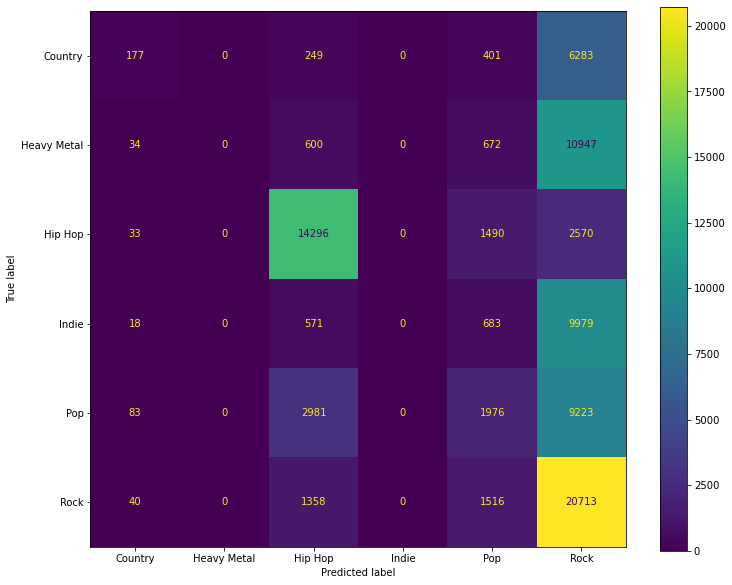

In [396]:
# confusion matrices

def confusion_matrices(actual, pred):
    matrix = metrics.confusion_matrix(actual, pred)
    labels = ['Country', 'Heavy Metal', 'Hip Hop', 'Indie', 'Pop', 'Rock']
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = labels)

    fig, ax = plt.subplots(figsize=(12,10))
    cm_display.plot(ax=ax)
    plt.show()
    
confusion_matrices(labels.tolist(), y_pred_lstm)